## We try to see what a popular image model has learnt using the idea described in the following paper

[Visualizing Higher-Layer Features of a Deep Network by Erhan et al.](https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network)

[The article that helped](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030)

## In Our case, we use the pre-trained VGG16 model

**We use the pre-trained model because training a new model requires a lot of hardware (read GPUs) and even then take might days to converge.**

## IMPORTANT NOTE

**<span style="color:red;"><b>Before running this notebook, make sure you are in virtual environment (so that the packages are not installed by this notebook globally)</b></span>**

**<span style="color:red;"><b>Also this code works ONLY IF you have a GPU installed.</b></span>**

# The Technique

### Steps:

1. We start with a picture containing random pixels.


2. We apply the pre-network in evaluation mode to this random image


3. Calculate the average activation of a particular feature map within a specific layer of the network from which we then compute the gradients with respect to the random input image pixel values.


4. Knowing the gradients for the pixel values we then proceed to update the pixel values in a way that maximizes the average activation of the chosen feature map.

    When we actually do that, we notice very high frequency patterns in the resulting optimised image. The more you train, the higher the frequency of the pattern. To deal with it, we start with a low-resolution image, then scale it up after every training (optimisation) step and blur it a little. This produces smoother images that does indded show some patterns.

**<span style="color:red;"><b>Warning: The code only works if a GPU is available on the machine</b></span>**

### Install and Import necessary libraries

In [ ]:
!pip3 install torch torchvision matplotlib fastai

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage
# from fastai.vision.learner import *
# from fastai import *
from fastai.basics import *
from cv2 import resize
import matplotlib.gridspec as gridspec
from math import ceil
from IPython.display import HTML
from pdb import set_trace
import torchvision.models as models
from torchvision import *
from torch import *
# from scipy import ndimage

import gc

np.random.seed(seed)

In [38]:
import cv2
import matplotlib.gridspec as gridspec

In [8]:
from matplotlib.pyplot import savefig
import time

**The <span style="font-size:16px;color:brown"><b>SaveFeatures()</b></span> class below helps record the feature map activation values into a tensor that will be used later to calculate the mean activation and the optimisation routine would try to maximise that mean activation**

In [9]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()
    

**The <span style="font-size:16px;color:brown"><b>np2tensor</b></span> and <span style="font-size:16px;color:brown"><b>np2tensor2np</b></span> functions convert numpy n-dimensional data from a PIL image to a pytorch sensor and vice-versa respectively.**

In [10]:
def np2tensor(image,dtype):
    "Convert np.array (sz,sz,3) to tensor (1,3,sz,sz), imagenet normalized"

    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    
    #Imagenet norm
    mean=np.array([0.485, 0.456, 0.406])[...,np.newaxis,np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[...,np.newaxis,np.newaxis]
    a = (a-mean)/std
    a = np.expand_dims(a,0)
    return torch.from_numpy(a.astype(dtype, copy=False) )

def tensor2np(img_tensor):
    "Convert tensor (1,3,sz,sz) back to np.array (sz,sz,3), imagenet DEnormalized"
    a = np.squeeze(to_np(img_tensor))
    mean=np.array([0.485, 0.456, 0.406])[...,np.newaxis,np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[...,np.newaxis,np.newaxis]
    a = a*std + mean
    return np.transpose(a, (1,2,0))

The <span style="font-size:14px;color:brown"><b>FilterVisualizer</b></span> class's <span style="font-size:18px;color:olive"><b>visualise</b></span> method does the gradient ascent on imput image pixels using a specific convolutional layer's feature map mean value

In [11]:
class FilterVisualizer():
    def __init__(self,model):
        self.model = model

    def visualize(self, sz, layer, filter, upscaling_steps=12, upscaling_factor=1.2, lr=0.01, opt_steps=50, blur=5, print_losses=False):
        
        img = (np.random.random((sz,sz, 3)) * 20 + 128.)/255 # value b/t 0 and 1        
        activations = SaveFeatures(layer)  # register hook
        torch.cuda.empty_cache()
        for i in range(upscaling_steps):  
            # convert np to tensor + channel first + new axis, and apply imagenet norm
            img_tensor = np2tensor(img,np.float32)
            img_tensor = img_tensor.cuda()
            img_tensor.requires_grad_();
            if not img_tensor.grad is None:
                img_tensor.grad.zero_(); 
            
            
            optimizer = torch.optim.Adam([img_tensor], lr=lr, weight_decay=1e-6)
            if i > upscaling_steps/2:
                opt_steps_ = int(opt_steps*1.3)
            else:
                opt_steps_ = opt_steps
            for n in range(opt_steps_):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                _=self.model(img_tensor)
                loss = -1*activations.features[0, filter].mean()
                if print_losses:
                    if i%3==0 and n%5==0:
                        # print(f'{i} - {n} - {float(loss)}')
                        if loss == 0:
                            break
                loss.backward()
                optimizer.step()
            
            # convert tensor back to np
            img = tensor2np(img_tensor)
            self.output = img
            sz = int(upscaling_factor * sz)  # calculate new image size
            # print(f'Upscale img to: {sz}')
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
                
        activations.close()
        return np.clip(self.output, 0, 1)
    
    def get_transformed_img(self,img,sz):
        '''
        Scale up/down img to sz. Channel last (same as input)
        image: np.array [sz,sz,3], already divided by 255"    
        '''
        return cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)
    
    def most_activated(self, img, layer):
        '''
        image: np.array [sz,sz,3], already divided by 255"    
        '''
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC)
        activations = SaveFeatures(layer)
        img_tensor = np2tensor(img,np.float32)
        img_tensor = img_tensor.cuda()
        
        _=self.model(img_tensor)
        mean_act = [np.squeeze(to_np(activations.features[0,i].mean())) for i in range(activations.features.shape[1])]
        activations.close()
        return mean_act

### Initialise the <span style="font-size:16px;color:green"><b>VGG16</b></span> pre-trained model

In [12]:
m = models.vgg16(True).cuda().eval()

### Visualize Convolutional Layer Feature Maps

#### Initialise the FilterVisualizer class object

In [13]:
fv = FilterVisualizer(m)

#### Convolutional layers live in the first sequential layer of the VGG16 network.
We get a reference to them using **model.children()** method

In [14]:
mods = [*m.children()]

#### Now we choose the layer for which we want to visualise the feature maps

In [22]:
fil = mods[0][24]
fil_num = 24
fil

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

#### The following code creates and saves ALL feature maps for the `fil_num` layer
**<span style="color:red;"><b>Warning: The code takes a lot of time to run </b></span>**

Provide the **range** of feature maps (that you want to visualise) to the `range` function
Provide the **directory** where you want to save the feature maps in the `d` variable and SET `save_in_this_directory` to True. Otherwise the feature maps will be saved in the current directory

**<span style="color:green;"><b>Each visualisation takes about 10 mins to be computed andtherefore we show only one imag here to avoid congestion
More visualisations can be found in the attached report</b></span>**

In [35]:
save_in_this_directory = False
d = None
if not save_in_this_directory:
    if d is None:
        d = f"./Feature_Maps/ConvL{fil_num}"
        if not (os.path.exists(d) and os.path.isdir(d)):
            os.makedirs(d)
    if not (os.path.exists(d) and os.path.isdir(d)):
        os.makedirs(d)
elif d is None:
    raise Exception("Please provide a valid directory (value for variable d) to save images in")

## Feature Map from Convolutional Layer 2, Feature Map # 17

<Figure size 864x864 with 0 Axes>

Saving featuremap # 17 to /Users/navit/Documents/Project2/Feature_Maps/ConvL2/Seq_ConvL2_FeatureMap17


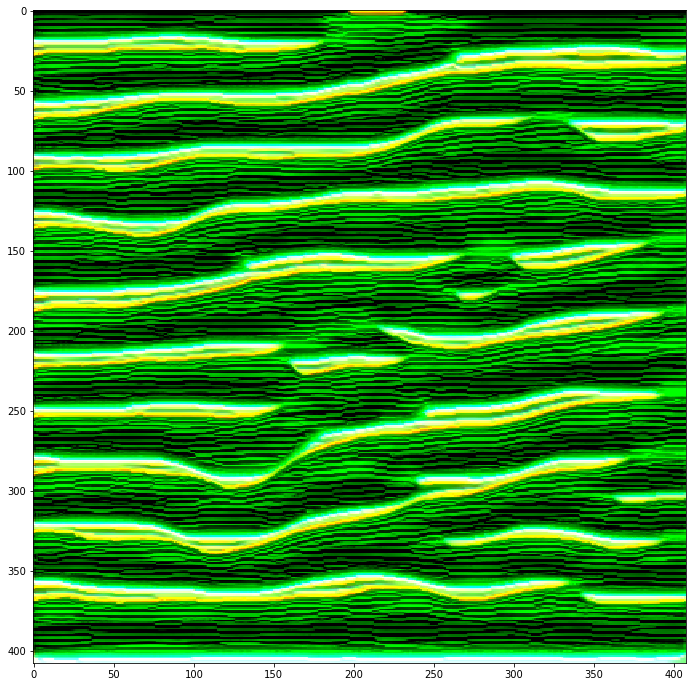

In [39]:
# Replace fil_num with layer number (out of [0,2,5,7,10,12,14,17,19,21,24,26,28]) and i with the feature map number
fil_num = 2
i = 17
fil = mods[0][fil_num]
d = f"./Feature_Maps/ConvL{fil_num}"

p = os.path.abspath(os.path.join(d,f"Seq_ConvL{fil_num}_FeatureMap{i}"))
img = fv.visualize(56,fil,i,upscaling_steps=12 ,lr=0.01, print_losses=True, opt_steps=100)
plt.figure(figsize = (12,12))
print(f"Saving featuremap # {i} to {p}")
plt.imshow(img)
plt.imsave(p,img)
torch.cuda.empty_cache()

## Feature Map from Convolutional Layer 24, Feature Map # 271

<Figure size 864x864 with 0 Axes>

Saving featuremap # 271 to /Users/navit/Documents/Project2/Feature_Maps/ConvL24/Seq_ConvL24_FeatureMap271


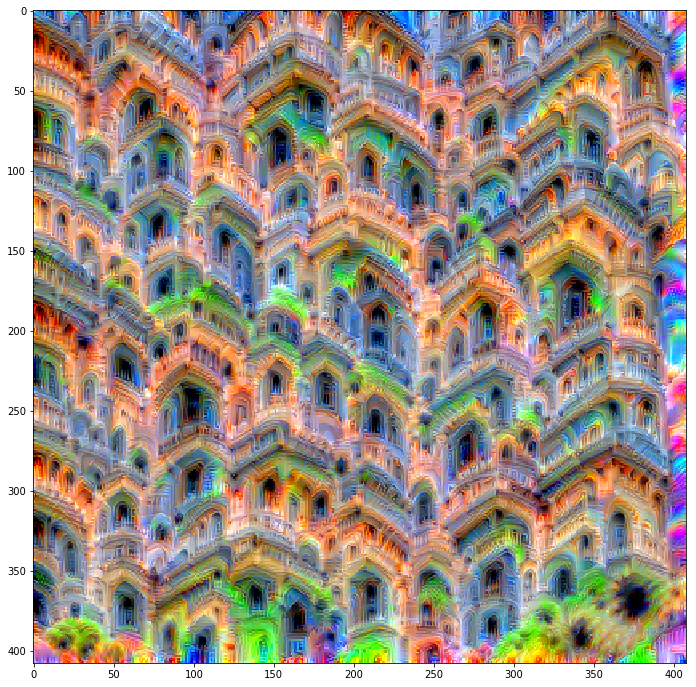

In [33]:
# Replace fil_num with layer number (out of [0,2,5,7,10,12,14,17,19,21,24,26,28]) and i with the feature map number
fil_num = 24
i = 271
fil = mods[0][fil_num]
d = f"./Feature_Maps/ConvL{fil_num}"

p = os.path.abspath(os.path.join(d,f"Seq_ConvL{fil_num}_FeatureMap{i}"))
img = fv.visualize(56,fil,i,upscaling_steps=12 ,lr=0.01, print_losses=True, opt_steps=100)
plt.figure(figsize = (12,12))
print(f"Saving featuremap # {i} to {p}")
plt.imshow(img)
plt.imsave(p,img)
torch.cuda.empty_cache()

## Feature Map from Convolutional Layer 24, Feature Map # 295

<Figure size 864x864 with 0 Axes>

Saving featuremap # 295 to /Users/navit/Documents/Project2/Feature_Maps/ConvL24/Seq_ConvL24_FeatureMap295


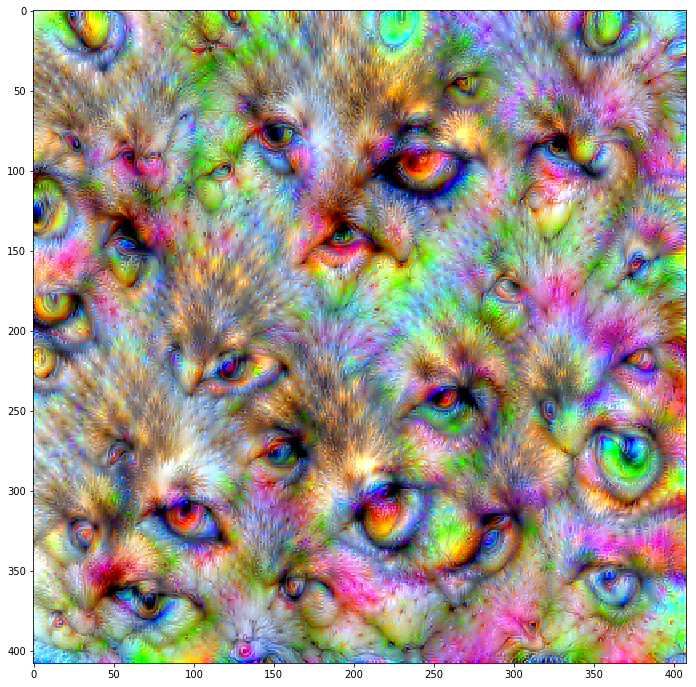

In [27]:
# Replace fil_num with layer number (out of [0,2,5,7,10,12,14,17,19,21,24,26,28]) and i with the feature map number
fil_num = 24
i = 295
fil = mods[0][fil_num]
d = f"./Feature_Maps/ConvL{fil_num}"

p = os.path.abspath(os.path.join(d,f"Seq_ConvL{fil_num}_FeatureMap{i}"))
img = fv.visualize(56,fil,i,upscaling_steps=12 ,lr=0.01, print_losses=True, opt_steps=100)
plt.figure(figsize = (12,12))
print(f"Saving featuremap # {i} to {p}")
plt.imshow(img)
plt.imsave(p,img)
torch.cuda.empty_cache()

## Feature Map from Convolutional Layer 24 , Feature Map # 201

<Figure size 864x864 with 0 Axes>

Saving featuremap # 201 to /Users/navit/Documents/Project2/Feature_Maps/ConvL24/Seq_ConvL24_FeatureMap201


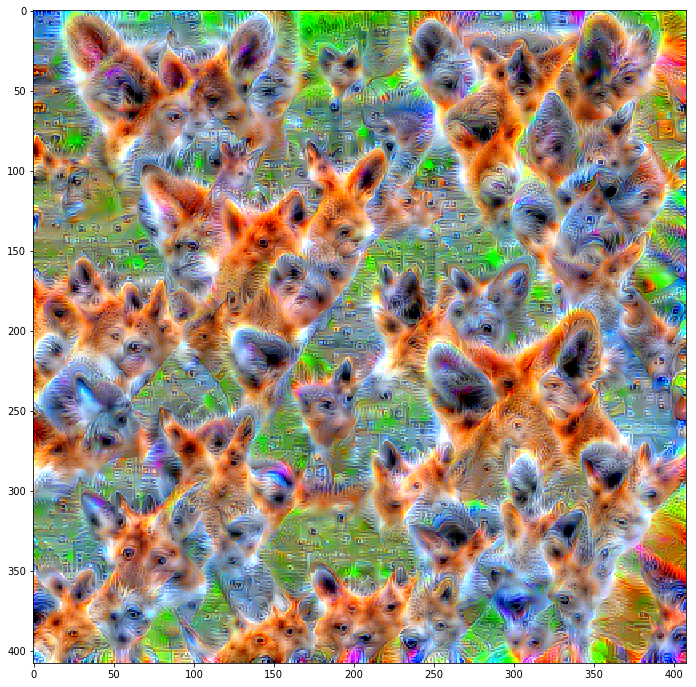

In [28]:
# Replace fil_num with layer number (out of [0,2,5,7,10,12,14,17,19,21,24,26,28]) and i with the feature map number
fil_num = 24
i = 201
fil = mods[0][fil_num]
d = f"./Feature_Maps/ConvL{fil_num}"

p = os.path.abspath(os.path.join(d,f"Seq_ConvL{fil_num}_FeatureMap{i}"))
img = fv.visualize(56,fil,i,upscaling_steps=12 ,lr=0.01, print_losses=True, opt_steps=100)
plt.figure(figsize = (12,12))
print(f"Saving featuremap # {i} to {p}")
plt.imshow(img)
plt.imsave(p,img)
torch.cuda.empty_cache()

## Feature Map from Convolutional Layer 28 , Feature Map # 98

<Figure size 864x864 with 0 Axes>

Saving featuremap # 98 to /Users/navit/Documents/Project2/Feature_Maps/ConvL24/Seq_ConvL28_FeatureMap98


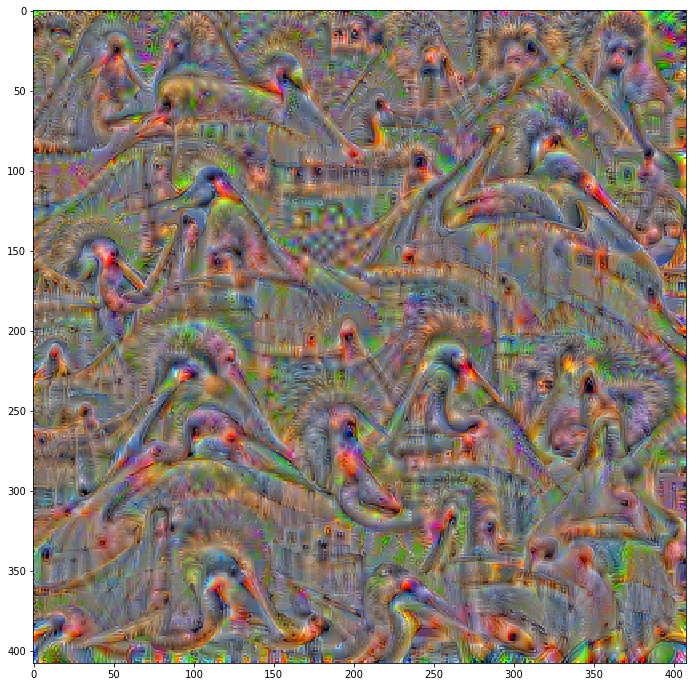

In [29]:
# Replace fil_num with layer number (out of [0,2,5,7,10,12,14,17,19,21,24,26,28]) and i with the feature map number
fil_num = 28
i = 98
fil = mods[0][fil_num]
d = f"./Feature_Maps/ConvL{fil_num}"

p = os.path.abspath(os.path.join(d,f"Seq_ConvL{fil_num}_FeatureMap{i}"))
img = fv.visualize(56,fil,i,upscaling_steps=12 ,lr=0.01, print_losses=True, opt_steps=100)
plt.figure(figsize = (12,12))
print(f"Saving featuremap # {i} to {p}")
plt.imshow(img)
plt.imsave(p,img)
torch.cuda.empty_cache()

## Feature Map from Convolutional Layer 28 , Feature Map # 390

<Figure size 864x864 with 0 Axes>

Saving featuremap # 390 to /Users/navit/Documents/Project2/Feature_Maps/ConvL24/Seq_ConvL28_FeatureMap390


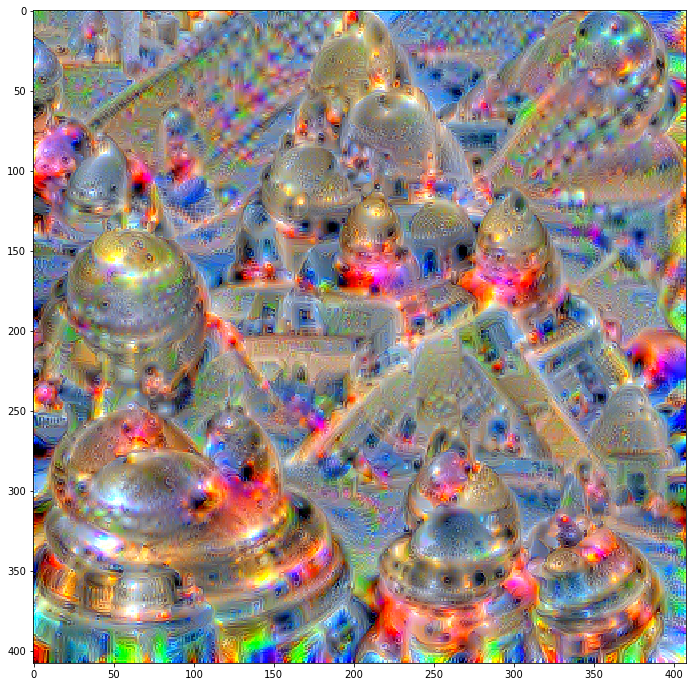

In [32]:
# Replace fil_num with layer number (out of [0,2,5,7,10,12,14,17,19,21,24,26,28]) and i with the feature map number
fil_num = 28
i = 390
fil = mods[0][fil_num]
d = f"./Feature_Maps/ConvL{fil_num}"

p = os.path.abspath(os.path.join(d,f"Seq_ConvL{fil_num}_FeatureMap{i}"))
img = fv.visualize(56,fil,i,upscaling_steps=12 ,lr=0.01, print_losses=True, opt_steps=100)
plt.figure(figsize = (12,12))
print(f"Saving featuremap # {i} to {p}")
plt.imshow(img)
plt.imsave(p,img)
torch.cuda.empty_cache()

## The following can be used to generate and save ALL feature maps for a layer in one go

In [ ]:
fil_num = 24
fil = mods[0][fil_num]
for i in range(0,128):
    p = os.path.abspath(os.path.join(d,f"Seq_ConvL{fil_num}_FeatureMap{i}"))
    img = fv.visualize(56,fil,i,upscaling_steps=12 ,lr=0.01, print_losses=True, opt_steps=100)    
    print(f"Saving featuremap # {i} to {p}")
    plt.imsave(p,img)
    torch.cuda.empty_cache()
    time.sleep(10)
print("Done")

### The following code shows nuber of feature maps in each of the Convolutional Layers

In [31]:
conv_layers = [0,2,5,7,10,12,14,17,19,21,24,26,28]
image_file_name = "cat.jpg"
image_file_path = os.path.abspath(os.path.join("./Test",image_file_name))
img = np.array(PIL.Image.open(image_file_path).convert('RGB')).astype(np.float32)/255
img = cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC)
img_tensor = np2tensor(img,np.float32)
img_tensor = img_tensor.cuda()
print("ConvL TensorSize Num_Maps")
for cl in conv_layers:
    this_layer = mods[0][cl]
    activations = SaveFeatures(this_layer)
    _ = fv.model(img_tensor)
    print(f"ConvL{cl} {activations.features.shape} {len(activations.features[0])}")

ConvL TensorSize Num_Maps
ConvL0 torch.Size([1, 64, 224, 224]) 64
ConvL2 torch.Size([1, 64, 224, 224]) 64
ConvL5 torch.Size([1, 128, 112, 112]) 128
ConvL7 torch.Size([1, 128, 112, 112]) 128
ConvL10 torch.Size([1, 256, 56, 56]) 256
ConvL12 torch.Size([1, 256, 56, 56]) 256
ConvL14 torch.Size([1, 256, 56, 56]) 256
ConvL17 torch.Size([1, 512, 28, 28]) 512
ConvL19 torch.Size([1, 512, 28, 28]) 512
ConvL21 torch.Size([1, 512, 28, 28]) 512
ConvL24 torch.Size([1, 512, 14, 14]) 512
ConvL26 torch.Size([1, 512, 14, 14]) 512
ConvL28 torch.Size([1, 512, 14, 14]) 512
